In [1]:
from io import StringIO
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data_file = "/disco-grande/datos.csv"
df = pd.read_csv(data_file)

In [4]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols = [col for col in categorical_cols if col != 'disposition']

In [5]:
float_feature_mask = df.dtypes==np.float64
int64_feature_mask = df.dtypes==np.int64
int32_feature_mask = df.dtypes==np.int32
uint8_feature_mask = df.dtypes==np.uint8
numeric_cols = df.columns[uint8_feature_mask].tolist() + df.columns[float_feature_mask].tolist() + df.columns[int64_feature_mask].tolist() + df.columns[int32_feature_mask].tolist()

In [6]:
df["disposition"] =  df["disposition"].apply(lambda x: 1 if x  == 'Admit' else 0)
# ONE HOT ENCODING de categoricos
df = pd.get_dummies(df, columns=categorical_cols)

In [7]:
null_columns= []
for col in df.columns:
    num_nulos = df[col].isna().sum()
    if num_nulos:
        null_columns.append((col, num_nulos))

In [9]:
for col, l in null_columns:
    df[col] = df[col].fillna(0)

In [10]:
total_count = len(df)
NULL_THREESHOLD = 0.4
exclude_columns = [col for col, count in null_columns if  count / total_count > NULL_THREESHOLD  ]
feat_labels = [col  for col in df.columns if col != 'disposition' and col not in exclude_columns]

In [16]:
null_columns

[('absolutelymphocytecount_last', 342560),
 ('acetonebld_last', 560090),
 ('alanineaminotransferase(alt)_last', 434832),
 ('albumin_last', 448952),
 ('alkphos_last', 433755),
 ('anc(absneutrophilcount)_last', 340278),
 ('aniongap_last', 348985),
 ('aspartateaminotransferase(ast)_last', 437527),
 ('b-typenatriureticpeptide,pro(probnp)_last', 549577),
 ('baseexcess(poc)_last', 519337),
 ('baseexcess,venous(poc)_last', 544752),
 ('basos_last', 340264),
 ('basosabs_last', 513915),
 ('benzodiazepinesscreen,urine,noconf._last', 560485),
 ('bilirubindirect_last', 505193),
 ('bilirubintotal_last', 434647),
 ('bun_last', 347614),
 ('bun/creatratio_last', 393885),
 ('calcium_last', 346287),
 ('calculatedco2(poc)_last', 515093),
 ('calculatedhco3(poc)i_last', 521492),
 ('calculatedo2saturation(poc)_last', 519388),
 ('chloride_last', 347535),
 ('cktotal_last', 548194),
 ('co2_last', 347665),
 ('co2calculated,venous(poc)_last', 544784),
 ('co2,poc_last', 509235),
 ('creatinine_last', 347595),
 ('d-

In [11]:
X = df[feat_labels]
Y = df['disposition']
random_state=42
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=random_state)
del X
del Y

In [12]:
n_splits = 4
def execute_model_base(model, cv = None, X_train = X_train, X_test = X_test, print_score=True, plot = True):
  if cv:
    for (train_idx, test_idx) in cv.split(X_train,Y_train):
      if type(X_train) == np.ndarray:
        model.fit(X_train[train_idx], Y_train[train_idx] if type(Y_train) == np.ndarray else Y_train.iloc[train_idx])
      else:
        model.fit(X_train.iloc[train_idx], Y_train.iloc[train_idx])
  else:
    model.fit(X_train, Y_train)

  Y_pred = model.predict(X_test)
  score = accuracy_score(Y_test, Y_pred)
  precision = precision_score(Y_test, Y_pred)
  recall = recall_score(Y_test, Y_pred)
  auc = roc_auc_score(Y_test, Y_pred)
  if print_score:
    print("Score = {0:.5f} ".format(score))
    print("Precision = {0:.5f} ".format(precision))
    print("Recall = {0:.5f} ".format(recall))  
    print("AUC = {0:.5f}".format(auc))
  conf_matrix = confusion_matrix(Y_pred, Y_test)
  if plot:
    sns.heatmap(conf_matrix,annot=True,fmt="d")
    plt.show()
def execute_model_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=KFold(n_splits=n_splits, random_state = random_state), *args, **kwargs)
def execute_model_stratified_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=StratifiedKFold(n_splits=n_splits, random_state = random_state), *args, **kwargs)
def execute_model_repeated_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=RepeatedKFold(n_repeats=8, n_splits=n_splits, random_state = random_state), *args, **kwargs)
def print_feature_importance_lgbm(model):
  feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
  return feature_imp.sort_values("Value", ascending =False)
#   plt.figure(figsize=(20, 10))
#   sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
#   plt.title('LightGBM Features (avg over folds)')
#   plt.tight_layout()
#   plt.show()
def print_feature_importance_rf(model):
  sfm = SelectFromModel(model)
  sfm.fit(X_train, Y_train)
  for feature_list_index in sfm.get_support(indices=True):
      print(feat_labels[feature_list_index])

/disco-grande/projects/proyecto-hospital/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score = 0.85062 
Precision = 0.83537 
Recall = 0.62044 
AUC = 0.78431


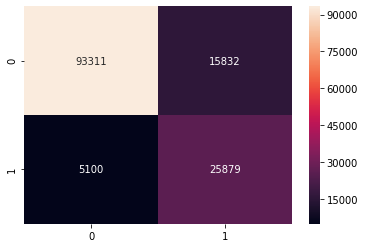

In [13]:
model_rf = RandomForestClassifier()
execute_model_stratified_kfold(model_rf)

Score = 0.84995 
Precision = 0.71157 
Recall = 0.83395 
AUC = 0.84534


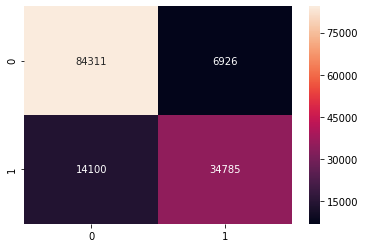

In [14]:
model = LGBMClassifier(objective='binary', is_unbalance=True, boosting_type='gbdt', max_depth=20, num_leaves=50)
execute_model_stratified_kfold(model)

In [15]:
print_feature_importance_lgbm(model)

,Value,Feature
691,232,esi
690,197,age
689,139,triage_vital_hr
688,121,n_edvisits
687,121,n_admissions
686,110,triage_vital_temp
685,103,dep_name_A
684,98,meds_cardiovascular
683,88,meds_psychotherapeuticdrugs
682,81,triage_vital_dbp
